In [184]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.decomposition import PCA 
from sklearn.feature_selection import VarianceThreshold,SelectFromModel
from sklearn.linear_model import LogisticRegression,SGDClassifier,Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from scipy.stats import pearsonr

import sys

In [185]:
ids = []
with open('/home/thomas/git/datascience/MSDataSci/505/data/project_three/ids.txt') as id_file:
    for line in id_file:
        line = line.replace('.txt\n','')
        ids.append(line)

iqs = []
iqs_labels = []
iqs_binary_labels = []
iqs_ternary_labels = []
matrices = []
vectors = []
data_dict = {}
i = 0
for id in ids:
    data_dict[id] = {}
    with open('/home/thomas/git/datascience/MSDataSci/505/data/project_three/dataset/{}.txt'.format(id)) as iq_file:
        iq = float(iq_file.readline().replace('\n',''))
        iqs.append(np.array([iq]))
        iqs_labels.append([iq,int(0 if iq<100 else 1),str('above average' if iq>110 else ('below average' if iq<90 else 'average'))])
        iqs_binary_labels.append(int(0 if iq<100 else 1))
        iqs_ternary_labels.append(str('above average' if iq>110 else ('below average' if iq<90 else 'average')))
        data_dict[id]['iq'] = [iq,int(0 if iq<100 else 1),str('above average' if iq>110 else ('below average' if iq<90 else 'average'))]
    
    matrix = np.genfromtxt('/home/thomas/git/datascience/MSDataSci/505/data/project_three/dataset/{}.csv'.format(id),delimiter=',') 
    vector = np.array([np.array(np.genfromtxt('/home/thomas/git/datascience/MSDataSci/505/data/project_three/dataset/{}_vec.csv'.format(id),delimiter=','))])

    matrices.append(matrix)
    vectors.append(vector[0])

    data_dict[id]['pid'] = i
    data_dict[id]['matrix'] = matrix
    data_dict[id]['vector'] = vector

    i += 1

matrices = np.array(matrices)
vectors = np.array(vectors)
iqs = np.array(iqs)
iqs_binary_labels = np.array(iqs_binary_labels)
iqs_ternary_labels = np.array(iqs_ternary_labels)
regions = list(csv.reader(open("/home/thomas/git/datascience/MSDataSci/505/data/project_three/Atlas_regions.csv")))

In [186]:
# mean_log_dist = exp(mu+((sigma**2)/2))
pca = PCA(.8)
pca.fit(vectors)
vectors = pca.fit_transform(vectors)

In [195]:
log_reg_scores = []
skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(vectors,iqs_binary_labels):
    vectors_train, vectors_test = vectors[train_index], vectors[test_index]
    iqs_binary_labels_train, iqs_binary_labels_test = iqs_binary_labels[train_index], iqs_binary_labels[test_index]

    log_reg = linear_model.LogisticRegression(solver='lbfgs')
    log_reg.fit(vectors_train,iqs_binary_labels_train)
    Yhat = linreg.predict(vectors_test)
    log_reg_scores.append(pearsonr(iqs_binary_labels_test, Yhat)[0]**2)
print('scores mean: {} and stdev: {}'.format(np.mean(log_reg_scores),np.std(log_reg_scores)))

scores mean: 0.5182710709702577 and stdev: 0.4817289290297423


2 folds gives: scores mean: 0.007826899989106847 and stdev: 0.0006790404423904894
3 folds gives: scores mean: 0.05168675509866808 and stdev: 0.01649307878129829
4 folds gives: scores mean: 0.08861231628444285 and stdev: 0.05765217150604943
5 folds gives: scores mean: 0.1643964035006689 and stdev: 0.0626281820672061
6 folds gives: scores mean: 0.13243592125792789 and stdev: 0.13094325025420506
7 folds gives: scores mean: 0.19469546550596917 and stdev: 0.15369280757157547
8 folds gives: scores mean: 0.1745683225195132 and stdev: 0.1377724983797662
9 folds gives: scores mean: 0.09748137749596603 and stdev: 0.11953066438914269
10 folds gives: scores mean: 0.2247529626292654 and stdev: 0.2487607907823456
11 folds gives: scores mean: 0.37217504839679133 and stdev: 0.3314968651082916
12 folds gives: scores mean: 0.18924389233247785 and stdev: 0.15503544373479114
13 folds gives: scores mean: 0.17181255221092584 and stdev: 0.20327893522885107
14 folds gives: scores mean: 0.33637086471591504 and

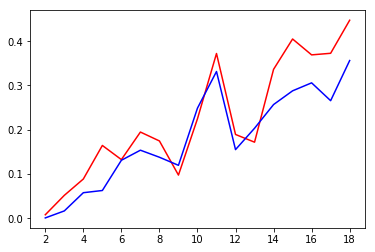

In [171]:
fold_test_x = []
fold_test_means = []
fold_test_stds = []
for i in range(2,19):
    kf = KFold(n_splits=i,shuffle=True)
    scores = []
    for train_index, test_index in kf.split(vectors,iqs):

        vectors_train, vectors_test = vectors[train_index], vectors[test_index]
        iqs_train, iqs_test = iqs[train_index], iqs[test_index]

        linreg = linear_model.LinearRegression()
        linreg.fit(vectors_train,iqs_train)
        Yhat = linreg.predict(vectors_test)
        scores.append((pearsonr(iqs_test, Yhat)[0]**2)[0])

        # plt.hist(vectors[:,0],bins=10)
        # plt.hist(new_columns[8],bins=10)
        # plt.show()

        # plt.boxplot(vectors[:,0:50])

        # plt.boxplot(vectors[:,51:100])
        # plt.show()

    print('{} folds gives: scores mean: {} and stdev: {}'.format(i,np.mean(scores),np.std(scores)))
    fold_test_means.append(np.mean(scores))
    fold_test_x.append(i)
    fold_test_stds.append(np.std(scores))

plt.plot(fold_test_x,fold_test_means, color='red')
plt.plot(fold_test_x,fold_test_stds, color='blue')

# plt.hist(scores,bins=6)
# plt.show()


In [110]:

# sys.exit()






# sys.exit('')


# def graphdata(patientid):
#     iq=data_dict[patientid]['iq']
#     plt.figure(figsize = [10,10])
#     plt.imshow(data_dict[patientid]['matrix'])
#     plt.set_cmap('hot')
#     plt.colorbar()
#     plt.title( f"IQ Score of {iq} ")
#     plt.show()


# graphdata('NS061')






# pipe_steps = [  ('feature_engineering', [
#                     ('VT', VarianceThreshold()),
#                     ('PCA', PCA())]),
#                 ('scaler', [
#                     ('standard', StandardScaler()),
#                     ('minmax', MinMaxScaler())]),
#                 ('classifier', [
#                     ('LR', LogisticRegression()),
#                     ('SVC', SVC()),
#                     ('SGD', SGDClassifier())])]

# # Grid search parameters for our models
# param_grid = {'LR': {'penalty': ['l1', 'l2']},
#               'SVC': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
#               'SGD': {'penalty': ['elasticnet'],
#                       'l1_ratio': [0.1, 0.2, 0.3]}}

# # Quality metric that we want to optimize
# scoring='roc_auc'

# # Setting cross-validations
# grid_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# eval_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# # >>> anova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])
# # >>> # You can set the parameters using the names issued
# # >>> # For instance, fit using a k of 10 in the SelectKBest
# # >>> # and a parameter 'C' of the svm
# # >>> anova_svm.set_params(anova__k=10, svc__C=.1).fit(X, y)